In [1]:
%matplotlib inline
%pip freeze > requirements.txt

Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
import pandas as pd
from heisenberg import HeisenbergModel, get_n_steps, get_prob0
from qiskit_ibm_runtime import QiskitRuntimeService, SamplerV2 as Sampler, Batch
from qiskit_aer import AerSimulator

# データセット作成 $\exp(-\beta H)$

In [3]:
n_samples = 25
n_qubits = 4
beta = 1

In [4]:
# Option1: Use IBM Quantum backend.
# If you did not previously save your credentials, use the following line instead:
# service = QiskitRuntimeService(channel="ibm_quantum", token="<MY_IBM_QUANTUM_TOKEN>")
service = QiskitRuntimeService()
backend_qpu = service.least_busy(simulator=False, operational=True)
# backend_qpu = service.backend("ibm_fez")

# Option2: Use local AerSimulator as the backend.
backend_sim = AerSimulator()

print(f"Using backend QPU: {backend_qpu}")
print(f"Using backend simulator: {backend_sim}")

Using backend QPU: <IBMBackend('ibm_brussels')>
Using backend simulator: AerSimulator('aer_simulator')


In [5]:
# State |111000> (half 1 and half 0 state) (can be adjusted for other sizes)
state = np.zeros(2**n_qubits, dtype=complex)
index = int("1" * (n_qubits // 2) + "0" * (n_qubits // 2), 2)
state[index] = 1

In [6]:
rng = np.random.default_rng(42)
data = []
eigvals = []
for i in range(n_samples):
    Js = rng.uniform(-1, 1, n_qubits - 1)
    heisenberg = HeisenbergModel(n_qubits, Js)
    H = heisenberg.get_hamiltonian()

    eigvals.append(np.linalg.eigvalsh(H))

    fH = scipy.linalg.expm(-beta * H)

    # Compute the expectation value <111000|exp(-beta*H)|111000>
    y = np.vdot(state, fH @ state).real
    data.append({"Js": Js, "expected_value": y})

df = pd.DataFrame(data)
df

,Js,expected_value
0,"[0.5479120971119267, -0.12224312049589536, 0.7...",3.791289
1,"[0.3947360581187278, -0.8116453042247009, 0.95...",12.441517
2,"[0.5222794039807059, 0.5721286105539076, -0.74...",0.964807
3,"[-0.09922812420886573, -0.25840395153483753, 0...",8.332811
4,"[0.2877302401613291, 0.64552322654166, -0.1131...",0.375753
5,"[-0.5455225564304462, 0.1091695740316696, -0.8...",1.706230
6,"[0.6552623439851641, 0.2633287982441297, 0.516...",1.652264
7,"[-0.2909480637402633, 0.9413960487898065, 0.78...",5.060376
8,"[0.5567669941475237, -0.6107225842960649, -0.0...",0.998235
9,"[-0.9123924684255424, -0.6914210158649043, 0.3...",8.213326


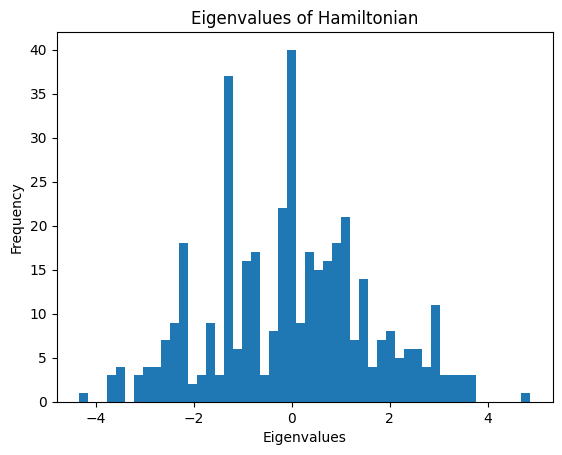

In [7]:
# Plot histogram of eigenvalues
eigvals = np.array(eigvals).flatten()
plt.hist(eigvals, bins=50)
plt.xlabel("Eigenvalues")
plt.ylabel("Frequency")
plt.title("Eigenvalues of Hamiltonian")
plt.show()

In [8]:
# Parameters for the Fourier feature generation
C = 3 * n_qubits  # upper bound for eigenvalues
n_features = 5  # Number of Fourier features

# ks = range(n_features)
times = [k * np.pi / C for k in range(n_features)]
print(times)

[0.0, 0.2617993877991494, 0.5235987755982988, 0.7853981633974483, 1.0471975511965976]


## Fourier feature の生成 (Exact simulation)

In [9]:
# Exact simulation
data = []
prob_phase0s_exact = []
prob_phase1s_exact = []
prob_phase2s_exact = []
prob_phase3s_exact = []

# Generate the dataset with Fourier features
for index, row in df.iterrows():
    Js = row["Js"]
    lambda_ref = np.sum(Js)  # Reference eigenvalue.
    features = []

    # Compute the Fourier features for different times
    for t in times:
        heisenberg = HeisenbergModel(n_qubits, Js)
        prob_phase0 = heisenberg.exact_simulation(t, phase=0)
        prob_phase1 = heisenberg.exact_simulation(t, phase=1)
        prob_phase2 = heisenberg.exact_simulation(t, phase=2)
        prob_phase3 = heisenberg.exact_simulation(t, phase=3)
        prob_phase0s_exact.append(prob_phase0)
        prob_phase1s_exact.append(prob_phase1)
        prob_phase2s_exact.append(prob_phase2)
        prob_phase3s_exact.append(prob_phase3)

        inner_product = np.exp(-1j * lambda_ref * t) * (
            (prob_phase0 - prob_phase1) + 1j * (prob_phase2 - prob_phase3)
        )
        features.append(inner_product.real)
        if t != times[0]:
            features.append(inner_product.imag)
    data.append([*features])

# Create column names for the DataFrame
columns = []
for k in range(n_features):
    columns.append(f"f_{k} Re")
    if k != 0:
        columns.append(f"f_{k} Im")

# Convert to a DataFrame
features_exact_df = pd.DataFrame(data, columns=columns)
display(features_exact_df)

,f_0 Re,f_1 Re,f_1 Im,f_2 Re,f_2 Im,f_3 Re,f_3 Im,f_4 Re,f_4 Im
0,1.0,0.928783,0.065886,0.740153,0.075106,0.499204,-0.002081,0.285339,-0.153338
1,1.0,0.822335,0.316658,0.403918,0.418554,0.011003,0.237211,-0.117266,-0.104111
2,1.0,0.816351,-0.441651,0.354556,-0.668684,-0.162974,-0.569342,-0.492269,-0.189132
3,1.0,0.855374,0.287077,0.483560,0.411089,0.042834,0.285421,-0.283408,-0.058749
4,1.0,0.960996,-0.270345,0.847260,-0.519371,0.668301,-0.727380,0.438939,-0.877857
5,1.0,0.893680,-0.094679,0.624991,-0.086877,0.318110,0.063012,0.105839,0.304656
6,1.0,0.958848,-0.107074,0.845810,-0.222429,0.687871,-0.345350,0.517915,-0.462331
7,1.0,0.918818,0.023492,0.720854,-0.012528,0.512101,-0.114567,0.389544,-0.225888
8,1.0,0.999397,-0.003292,0.997695,-0.006541,0.995181,-0.009717,0.992214,-0.012809
9,1.0,0.853005,0.488938,0.461492,0.826869,-0.045608,0.909336,-0.507723,0.714313


## Fourier feature の生成 (Trotter 近似, Simulator)

In [10]:
# Create circuits
# 1 jobs - 1 sample
all_circuits = []
lambda_refs = []

for index, row in df.iterrows():
    Js = row["Js"]
    lambda_refs.append(np.sum(Js))  # Reference eigenvalue.
    heisenberg_sim = HeisenbergModel(n_qubits, Js, backend=backend_sim)

    circuits_per_sample = []
    for k in range(n_features):
        n_steps = get_n_steps(times[k])
        isa_phase0 = heisenberg_sim.get_trotter_simulation_pub(
            times[k], n_steps, phase=0
        )
        isa_phase1 = heisenberg_sim.get_trotter_simulation_pub(
            times[k], n_steps, phase=1
        )
        isa_phase2 = heisenberg_sim.get_trotter_simulation_pub(
            times[k], n_steps, phase=2
        )
        isa_phase3 = heisenberg_sim.get_trotter_simulation_pub(
            times[k], n_steps, phase=3
        )
        circuits_per_sample += [isa_phase0, isa_phase1, isa_phase2, isa_phase3]
    all_circuits.append(circuits_per_sample)

In [11]:
# Run jobs in batch
jobs = []
with Batch(backend=backend_sim):
    sampler = Sampler()
    for i, circuits_per_sample in enumerate(all_circuits):
        sampler.options.environment.job_tags = [f"{i}"]
        # sampler.options.environment.callback = callback
        job = sampler.run(circuits_per_sample)
        jobs.append(job)

In [12]:
check_list = []
for i in range(n_samples):
    job_id = jobs[i].job_id()
    check_list.append(
        {
            "Job ID": job_id,
            "sample_id": i,
            "Status": job.status().name,
        }
    )

check_df = pd.DataFrame(check_list)
display(check_df)

,Job ID,sample_id,Status
0,681cbed7-0c60-4835-9e50-b8144cc8245b,0,DONE
1,e5cc06c2-4569-42a4-8c42-7b36d4b22b2b,1,DONE
2,6a57aefa-9c5e-4967-b953-c258b52029fb,2,DONE
3,10924d42-7bf2-497f-8e16-6d2df4556d4c,3,DONE
4,45d1bf23-f53a-474e-a146-3e3605306ec3,4,DONE
5,48ba21bd-5600-4683-be6d-fbe230eed668,5,DONE
6,77645c93-4c48-4c83-aec5-dc3c3ad6775c,6,DONE
7,76b5f93b-58ba-4be6-908d-228635298796,7,DONE
8,583c8c42-b6ea-4be4-9b18-b2e42affe2b9,8,DONE
9,5b0c62c3-5d4a-4185-9766-830f4cd67eed,9,DONE


In [13]:
# Post-process
data_sim = []
prob_phase0s_sim = []
prob_phase1s_sim = []
prob_phase2s_sim = []
prob_phase3s_sim = []

for sample, job in enumerate(jobs):
    features = []
    for k in range(n_features):
        prob_phase0 = get_prob0(job.result()[4 * k], n_qubits)
        prob_phase1 = get_prob0(job.result()[4 * k + 1], n_qubits)
        prob_phase2 = get_prob0(job.result()[4 * k + 2], n_qubits)
        prob_phase3 = get_prob0(job.result()[4 * k + 3], n_qubits)
        prob_phase0s_sim.append(prob_phase0)
        prob_phase1s_sim.append(prob_phase1)
        prob_phase2s_sim.append(prob_phase2)
        prob_phase3s_sim.append(prob_phase3)

        inner_product = np.exp(-1j * lambda_refs[sample] * times[k]) * (
            (prob_phase0 - prob_phase1) + 1j * (prob_phase2 - prob_phase3)
        )
        features.append(inner_product.real)
        if k != 0:
            features.append(inner_product.imag)
    data_sim.append([*features])

# Create column names for the DataFrame
columns = []
for k in range(n_features):
    columns.append(f"f_{k} Re")
    if k != 0:
        columns.append(f"f_{k} Im")

# Convert to a DataFrame
features_sim_df = pd.DataFrame(data_sim, columns=columns)
display(features_sim_df)

 > No counts for |0...0> state
 > No counts for |0...0> state
 > No counts for |0...0> state
 > No counts for |0...0> state
 > No counts for |0...0> state
 > No counts for |0...0> state
 > No counts for |0...0> state
 > No counts for |0...0> state
 > No counts for |0...0> state
 > No counts for |0...0> state
 > No counts for |0...0> state
 > No counts for |0...0> state
 > No counts for |0...0> state
 > No counts for |0...0> state
 > No counts for |0...0> state
 > No counts for |0...0> state
 > No counts for |0...0> state
 > No counts for |0...0> state
 > No counts for |0...0> state
 > No counts for |0...0> state
 > No counts for |0...0> state
 > No counts for |0...0> state
 > No counts for |0...0> state
 > No counts for |0...0> state
 > No counts for |0...0> state
 > No counts for |0...0> state


,f_0 Re,f_1 Re,f_1 Im,f_2 Re,f_2 Im,f_3 Re,f_3 Im,f_4 Re,f_4 Im
0,1.0,0.934431,0.067408,0.735967,0.080918,0.508343,0.009431,0.241499,-0.147558
1,1.0,0.838380,0.308972,0.377972,0.427889,-0.017325,0.224809,-0.115225,-0.121417
2,1.0,0.822061,-0.476777,0.391883,-0.665739,-0.140390,-0.572255,-0.495211,-0.183060
3,1.0,0.855980,0.280214,0.493413,0.419612,0.087496,0.272329,-0.295080,-0.083290
4,1.0,0.961817,-0.273700,0.849809,-0.506190,0.667735,-0.727347,0.447747,-0.879029
5,1.0,0.887305,-0.112754,0.636631,-0.087572,0.268221,0.034330,0.124386,0.293621
6,1.0,0.962506,-0.096126,0.809567,-0.216238,0.675433,-0.326515,0.534779,-0.462622
7,1.0,0.941471,0.057622,0.701079,0.005976,0.493911,-0.089114,0.358906,-0.231614
8,1.0,0.999081,0.013945,0.999828,-0.012172,0.999523,0.000718,0.993017,-0.005919
9,1.0,0.863944,0.461183,0.420610,0.834155,-0.006638,0.924263,-0.502972,0.721063


## Fourier feature の生成 (Trotter 近似, QPU)

In [14]:
# For the case session is expired, you can reinitialize the service with the following line.
backend_qpu = service.backend(backend_qpu.name)

In [15]:
# Create circuits
# 1 jobs - 1 sample
all_circuits = []
lambda_refs = []

for index, row in df.iterrows():
    Js = row["Js"]
    lambda_refs.append(np.sum(Js))  # Reference eigenvalue.
    heisenberg_qpu = HeisenbergModel(n_qubits, Js, backend=backend_qpu)

    circuits_per_sample = []
    for k in range(n_features):
        n_steps = get_n_steps(times[k])
        isa_phase0 = heisenberg_qpu.get_trotter_simulation_pub(
            times[k], n_steps, phase=0
        )
        isa_phase1 = heisenberg_qpu.get_trotter_simulation_pub(
            times[k], n_steps, phase=1
        )
        isa_phase2 = heisenberg_qpu.get_trotter_simulation_pub(
            times[k], n_steps, phase=2
        )
        isa_phase3 = heisenberg_qpu.get_trotter_simulation_pub(
            times[k], n_steps, phase=3
        )
        circuits_per_sample += [isa_phase0, isa_phase1, isa_phase2, isa_phase3]
    all_circuits.append(circuits_per_sample)

In [16]:
# Run jobs in batch
jobs = []
with Batch(backend=backend_qpu):
    sampler = Sampler()
    for i, circuits_per_sample in enumerate(all_circuits):
        sampler.options.environment.job_tags = [f"{i}"]
        # sampler.options.environment.callback = callback
        job = sampler.run(circuits_per_sample)
        jobs.append(job)

# Save job IDs to a file
with open("job_ids_qpu.txt", "w") as f:
    for job in jobs:
        f.write(f"{job.job_id()}\n")

In [17]:
with open("job_ids_qpu.txt", "r") as f:
    job_ids = f.readlines()
    job_ids = [job_id.strip() for job_id in job_ids]

check_list = []
for i in range(n_samples):
    job_id = job_ids[i]
    job = service.job(job_id)
    sample_id = job.tags[0]
    check_list.append(
        {
            "Job ID": job_id,
            "sample_id": sample_id,
            "Status": job.status(),
        }
    )

check_df = pd.DataFrame(check_list)
display(check_df)

,Job ID,sample_id,Status
0,cwr9grk2ac5g008hxff0,0,DONE
1,cwr9gsb997wg008xedh0,1,DONE
2,cwr9gt32ac5g008hxfg0,2,DONE
3,cwr9gtvtdtng0086wyr0,3,DONE
4,cwr9gvvtdtng0086wyrg,4,ERROR
5,cwr9gwb5v39g008h77y0,5,DONE
6,cwr9gx3997wg008xedjg,6,DONE
7,cwr9gxv2ac5g008hxfh0,7,ERROR
8,cwr9gyk60bqg008p7vn0,8,DONE
9,cwr9gzk2ac5g008hxfhg,9,DONE


### Retry failed jobs

In [18]:
# Fetch failed jobs
failed_jobs = check_df[check_df["Status"] == "ERROR"]
failed_job_ids = failed_jobs["Job ID"].to_list()
failed_samples = failed_jobs["sample_id"].to_list()

print(f"Failed jobs: {failed_job_ids}")
print(f"Failed samples: {failed_samples}")

Failed jobs: ['cwr9gvvtdtng0086wyrg', 'cwr9gxv2ac5g008hxfh0', 'cwr9h5c60bqg008p7vqg']
Failed samples: ['4', '7', '17']


In [19]:
# Fetch failed circuits
failed_circuits = []

for failed_sample in failed_samples:
    failed_circuits.append(all_circuits[int(failed_sample)])

In [20]:
# Retry jobs in batch
retried_jobs = []
with Batch(backend=backend_qpu):
    sampler = Sampler()
    for i in range(len(failed_samples)):
        sampler.options.environment.job_tags = [f"{failed_samples[i]}", "retry"]
        retried_job = sampler.run(failed_circuits[i])
        retried_jobs.append(retried_job)

In [21]:
retried_check_list = []
for i in range(len(retried_jobs)):
    job_id = retried_jobs[i].job_id()
    retried_check_list.append(
        {
            "Job ID": job_id,
            "sample_id": failed_samples[i],
            "Status": retried_jobs[i].status(),
        }
    )

retried_check_df = pd.DataFrame(retried_check_list)
display(retried_check_df)

,Job ID,sample_id,Status
0,cwr9t582ac5g008hxgvg,4,DONE
1,cwr9t68ehebg008hzkp0,7,DONE
2,cwr9t7060bqg008p7x50,17,DONE


In [22]:
# Overwrite job IDs to a file
for i in range(len(failed_samples)):
    job_ids[int(failed_samples[i])] = retried_jobs[i].job_id()

with open("job_ids_qpu.txt", "w") as f:
    for job_id in job_ids:
        f.write(f"{job_id}\n")

In [23]:
# Post-process
jobs = []
with open("job_ids_qpu.txt", "r") as f:
    job_ids = f.readlines()
    job_ids = [job_id.strip() for job_id in job_ids]
    jobs = [service.job(job_id) for job_id in job_ids]

In [24]:
data_qpu = []
prob_phase0s_qpu = []
prob_phase1s_qpu = []
prob_phase2s_qpu = []
prob_phase3s_qpu = []

for sample, job in enumerate(jobs):
    features = []
    for k in range(n_features):
        prob_phase0 = get_prob0(job.result()[4 * k], n_qubits)
        prob_phase1 = get_prob0(job.result()[4 * k + 1], n_qubits)
        prob_phase2 = get_prob0(job.result()[4 * k + 2], n_qubits)
        prob_phase3 = get_prob0(job.result()[4 * k + 3], n_qubits)
        prob_phase0s_qpu.append(prob_phase0)
        prob_phase1s_qpu.append(prob_phase1)
        prob_phase2s_qpu.append(prob_phase2)
        prob_phase3s_qpu.append(prob_phase3)

        inner_product = np.exp(-1j * lambda_refs[sample] * times[k]) * (
            (prob_phase0 - prob_phase1) + 1j * (prob_phase2 - prob_phase3)
        )
        features.append(inner_product.real)
        if k != 0:
            features.append(inner_product.imag)
    data_qpu.append([*features])

# Create column names for the DataFrame
columns = []
for k in range(n_features):
    columns.append(f"f_{k} Re")
    if k != 0:
        columns.append(f"f_{k} Im")

# Convert to a DataFrame
features_qpu_df = pd.DataFrame(data_qpu, columns=columns)
display(features_qpu_df)

,f_0 Re,f_1 Re,f_1 Im,f_2 Re,f_2 Im,f_3 Re,f_3 Im,f_4 Re,f_4 Im
0,0.536133,0.065178,-0.558170,-0.320883,-0.017316,-0.147417,0.139435,0.090304,0.054586
1,0.538330,0.209064,-0.483335,-0.171379,-0.145592,-0.099521,0.004035,0.019405,0.022703
2,0.549072,-0.191990,-0.524894,-0.159619,0.282422,0.188111,0.100081,-0.006277,-0.138053
3,0.565918,0.204894,-0.497510,-0.207278,-0.146013,-0.099599,0.026101,0.067627,0.049924
4,0.549805,-0.153034,-0.566586,-0.248596,0.164310,0.062810,0.111291,-0.031264,0.036226
5,0.526123,-0.022590,-0.512214,-0.184024,0.036884,0.022308,0.029881,-0.000727,-0.068610
6,0.503662,-0.066756,-0.552613,-0.302315,0.137358,-0.032746,0.222330,0.113205,-0.016481
7,0.543701,0.034514,-0.530736,-0.231643,0.036882,0.018449,0.076818,-0.050739,-0.020741
8,0.540283,0.049271,-0.570507,-0.364059,-0.010772,-0.156296,0.160998,0.085855,0.095304
9,0.535156,0.323538,-0.462564,-0.153937,-0.314378,-0.162123,-0.159228,-0.099048,-0.031951


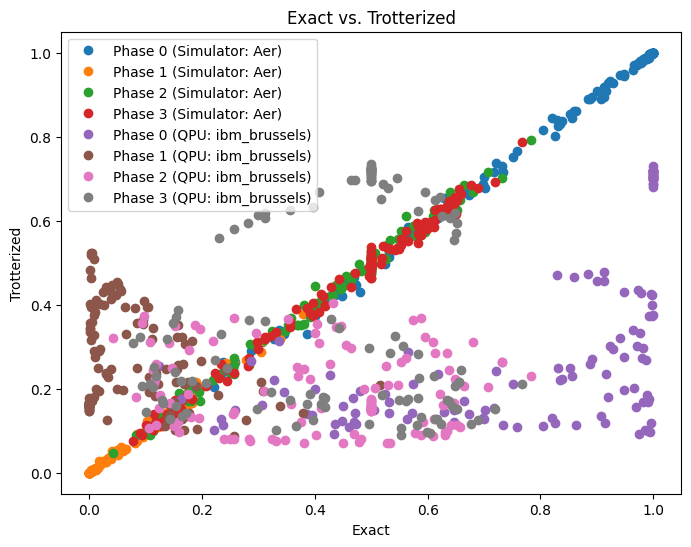

In [ ]:
# Plot exact vs. Trotterized results
plt.figure(figsize=(8, 6))
plt.plot(prob_phase0s_exact, prob_phase0s_sim, "o", label="Phase 0 (Simulator: Aer)")
plt.plot(prob_phase1s_exact, prob_phase1s_sim, "o", label="Phase 1 (Simulator: Aer)")
plt.plot(prob_phase2s_exact, prob_phase2s_sim, "o", label="Phase 2 (Simulator: Aer)")
plt.plot(prob_phase3s_exact, prob_phase3s_sim, "o", label="Phase 3 (Simulator: Aer)")
plt.plot(
    prob_phase0s_exact,
    prob_phase0s_qpu,
    "o",
    label=f"Phase 0 (QPU: {backend_qpu.name})",
)
plt.plot(
    prob_phase1s_exact,
    prob_phase1s_qpu,
    "o",
    label=f"Phase 1 (QPU: {backend_qpu.name})",
)
plt.plot(
    prob_phase2s_exact,
    prob_phase2s_qpu,
    "o",
    label=f"Phase 2 (QPU: {backend_qpu.name})",
)
plt.plot(
    prob_phase3s_exact,
    prob_phase3s_qpu,
    "o",
    label=f"Phase 3 (QPU: {backend_qpu.name})",
)
plt.xlabel("Exact")
plt.ylabel("Trotterized")
plt.legend()
plt.title("Exact vs. Trotterized")
plt.show()

## リッジ回帰

In [26]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge

In [34]:
test_size = 0.2

# Split the dataset into training and test sets
X_exact = features_exact_df
y_exact = df["expected_value"]
X_train_exact, X_test_exact, y_train_exact, y_test_exact = train_test_split(
    X_exact, y_exact, test_size=test_size, random_state=42
)

X_sim = features_sim_df
y_sim = df["expected_value"]
X_train_sim, X_test_sim, y_train_sim, y_test_sim = train_test_split(
    X_sim, y_sim, test_size=test_size, random_state=42
)

X_qpu = features_qpu_df
y_qpu = df["expected_value"]
X_train_qpu, X_test_qpu, y_train_qpu, y_test_qpu = train_test_split(
    X_qpu, y_qpu, test_size=test_size, random_state=42
)

# Train the Ridge regression model
alpha = 0.1
ridge_exact = Ridge(alpha=alpha, fit_intercept=False)
ridge_exact.fit(X_train_exact, y_train_exact)
y_pred_exact = ridge_exact.predict(X_test_exact)

ridge_sim = Ridge(alpha=alpha, fit_intercept=False)
ridge_sim.fit(X_train_sim, y_train_sim)
y_pred_sim = ridge_sim.predict(X_test_sim)

ridge_qpu = Ridge(alpha=alpha, fit_intercept=False)
ridge_qpu.fit(X_train_qpu, y_train_qpu)
y_pred_qpu = ridge_qpu.predict(X_test_qpu)

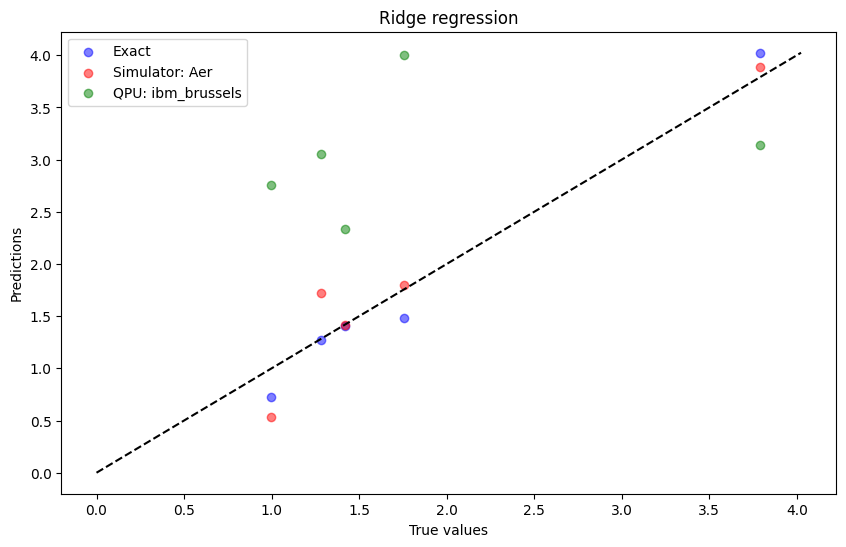

In [39]:
# Plot the results
plt.figure(figsize=(10, 6))
plt.scatter(y_test_exact, y_pred_exact, color="blue", label="Exact", alpha=0.5)
plt.scatter(y_test_sim, y_pred_sim, color="red", label="Simulator: Aer", alpha=0.5)
plt.scatter(
    y_test_qpu, y_pred_qpu, color="green", label=f"QPU: {backend_qpu.name}", alpha=0.5
)
# Plot the 1:1 line
xmax = max(y_test_exact.max(), y_pred_exact.max())
plt.plot([0, xmax], [0, xmax], color="black", linestyle="--")
plt.xlabel("True values")
plt.ylabel("Predictions")
plt.title(f"Ridge regression")
plt.legend()
plt.show()